In [1]:
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
#!pip install lingpy
#import lingpy
#from lingpy import ipa2tokens
import re

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device("cpu") #For debugging
print(f"Using device: {device}")
torch.set_default_device(device)

Using device: cuda


In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

## IELEX

In [3]:
import pandas as pd
from itertools import combinations

df = pd.read_csv("data/ielexData.csv")

df = df[['Meaning', 'Phonological Form', 'cc']].dropna()
df.columns = ['meaning', 'word', 'cognate_class']

ilexPairs = []

for _, group in df.groupby('meaning'):
    entries = group.to_dict('records')
    for w1, w2 in combinations(entries, 2):
        word1 = str(w1['word'])
        word2 = str(w2['word'])
        label = int(w1['cognate_class'] == w2['cognate_class'])
        ilexPairs.append((word1, word2, label))

import csv

# Initialize an empty set to store the languages
languages = set()

# Open and read the CSV file with UTF-8 encoding and error handling
with open('data/ielexData.csv', 'r', encoding='utf-8', errors='replace') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header row
    for row in reader:
        languages.add(row[1])  # Add the language (second column) to the set

# Print the set of languages
print(languages)

df

{'Welsh', 'Dutch', 'Swedish', 'Bulgarian', 'English', 'Polish', 'Catalan', 'Icelandic', 'Italian', 'Breton', 'Romanian', 'Spanish', 'Irish', 'Hindi', 'Lithuanian', 'Nepali', 'French', 'Ukrainian', 'Bengali', 'Czech', 'Portuguese', 'Greek', 'German', 'Russian', 'Danish'}


,meaning,word,cognate_class
0,few,ˈliʝi,few:I
1,few,ˈmaɫku,few:H
2,few,'maɫɔ,few:H
3,few,ˈmawɔ,few:H
4,few,ˈmaɫɔ,few:H
...,...,...,...
4479,head,tɛt,head:D
4480,head,'tɛsta,head:D
4481,head,kap,head:B
4482,head,ˈpɛnː,head:E


## GLED

### Preprocessing

In [4]:
df = pd.read_csv("data/gled.tsv", delimiter="\t")

df.rename(columns={'LANGUAGE_NAME': 'Language'}, inplace=True)

df['Language'] = df['Language'].str.replace('Modern Greek', 'Greek', regex=False)

# more_languages = {"English", "Spanish", "Hindi", "Portuguese", "Bengali", "Russian", "Japanese", "Punjabi", "German", "Vietnamese", "Javanese", "Malay/Indonesian", "Telugu", "Korean", "French", "Marathi", "Tamil", "Turkish", "Urdu", "Gujarati", "Polish", "Ukrainian", "Italian", "Malayalam", "Kannada", "Oriya", "Sundanese", "Romanian", "Hausa", "Burmese", "Thai", "Dutch", "Yoruba", "Sindhi", "Amharic", "Tagalog", "Nepali", "Cebuano", "Assamese", "Hungarian", "Sinhala", "Czech", "Greek", "Belarusan", "Somali", "Malagasy", "Zulu", "Bulgarian", "Swedish"}
# languages.update(more_languages)

df = df[df['Language'].isin(languages)]

#df = df[df.apply(lambda row: row['DOCULECT'].lower() in row['Language'].lower(), axis=1)]

#These languages seem to be aight
#df = df[df["DOCULECT"].str.contains("_2")]

#df.dropna(subset=["COGSET"], inplace=True) All of them have a cogset

df

,ID,DOCULECT,Language,GLOTTOCODE,GLOTTOLOG_NAME,FAMILY,CONCEPT,CONCEPTICON_ID,ASJP_FORM,FORM,IPA,ALIGNMENT,COGSET,COGSET_INT
144314,BRETON.1pl-3159,BRETON,Breton,bret1244,Breton,Indo-European,1pl,1212,ni,ni,n i,n i - - - -,indoeuropean.1pl.0001,18691
144315,BULGARIAN_2.1pl-3162,BULGARIAN_2,Bulgarian,bulg1262,Bulgarian,Indo-European,1pl,1212,niE,nia,n i a,n i - - - a,indoeuropean.1pl.0001,18691
144321,FRENCH_2.1pl-3210,FRENCH_2,French,stan1290,French,Indo-European,1pl,1212,nu,nu,n u,n u - - - -,indoeuropean.1pl.0001,18691
144324,ITALIAN_2.1pl-3242,ITALIAN_2,Italian,ital1282,Italian,Indo-European,1pl,1212,noi,noi,n o i,n o - - - i,indoeuropean.1pl.0001,18691
144325,ITALIAN_GROSSETO_TUSCAN.1pl-3243,ITALIAN_GROSSETO_TUSCAN,Italian,ital1282,Italian,Indo-European,1pl,1212,noi,noi,n o i,n o - - - i,indoeuropean.1pl.0001,18691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158460,IRISH_GAELIC.water-259902,IRISH_GAELIC,Irish,iris1253,Irish,Indo-European,water,948,iSky3,iʃkjə,i ʃ k j ə,- i - ʃ k j ə,indoeuropean.water.0950,19640
158464,GREEK.water-259881,GREEK,Greek,mode1248,Modern Greek,Indo-European,water,948,nero,nero,n e r o,n e r o,indoeuropean.water.0951,19641
158465,MODERN_GREEK.water-259969,MODERN_GREEK,Greek,mode1248,Modern Greek,Indo-European,water,948,nero,nero,n e r o,n e r o,indoeuropean.water.0951,19641
158481,HINDI_2.water-259895,HINDI_2,Hindi,hind1269,Hindi,Indo-European,water,948,j3l,dʒəl,dʒ ə l,dʒ ə l,indoeuropean.water.0961,19651


In [5]:
df = df[['CONCEPT', 'FORM', 'COGSET']].dropna()
df.columns = ['meaning', 'word', 'cognate_class']

pairs = []

from tqdm.notebook import tqdm
for _, group in tqdm(df.groupby('meaning')):
    #if len(pairs) > 100000:
    #    break

    entries = group.to_dict('records')
    for w1, w2 in combinations(entries, 2):
        word1 = str(w1['word'])
        word2 = str(w2['word'])
        if(word1 == word2):
            continue
        label = int(w1['cognate_class'] == w2['cognate_class'])
        #if label == 1:
        pairs.append((word1, word2, label))

  0%|          | 0/40 [00:00<?, ?it/s]

In [6]:
pairs += ilexPairs

In [7]:
pairs

[('ni', 'nia', 1),
 ('ni', 'nu', 1),
 ('ni', 'noi', 1),
 ('ni', 'noi', 1),
 ('ni', 'noʃ', 1),
 ('ni', 'noj', 1),
 ('ni', 'həm', 0),
 ('ni', 'ɐmrɐ', 0),
 ('ni', 'ma', 0),
 ('ni', 'mi', 0),
 ('ni', 'midj', 0),
 ('ni', 'mɐ', 0),
 ('ni', 'mes', 0),
 ('ni', 'mi', 0),
 ('ni', 'mə', 0),
 ('ni', 'mə', 0),
 ('ni', 'mi', 0),
 ('ni', 'noltros', 0),
 ('ni', 'nuzɐʎtrəs', 0),
 ('ni', 'nosotros', 0),
 ('ni', 'nosɐltres', 0),
 ('ni', 'vi', 0),
 ('ni', 'və', 0),
 ('ni', 'vai', 0),
 ('ni', 'wi', 0),
 ('ni', 'vir', 0),
 ('ni', 'vi', 0),
 ('ni', 'viθ', 0),
 ('ni', 'ʃinj', 0),
 ('ni', 'ʃiɲ', 0),
 ('ni', 'emis', 0),
 ('ni', 'emis', 0),
 ('ni', 'vɐalə', 0),
 ('nia', 'nu', 1),
 ('nia', 'noi', 1),
 ('nia', 'noi', 1),
 ('nia', 'noʃ', 1),
 ('nia', 'noj', 1),
 ('nia', 'ni', 1),
 ('nia', 'həm', 0),
 ('nia', 'ɐmrɐ', 0),
 ('nia', 'ma', 0),
 ('nia', 'mi', 0),
 ('nia', 'midj', 0),
 ('nia', 'mɐ', 0),
 ('nia', 'mes', 0),
 ('nia', 'mi', 0),
 ('nia', 'mə', 0),
 ('nia', 'mə', 0),
 ('nia', 'mi', 0),
 ('nia', 'noltros', 0),


In [8]:
pairs_df = pd.DataFrame(pairs, columns=['Word1', 'Word2', 'Label'])
pairs_df

,Word1,Word2,Label
0,ni,nia,1
1,ni,nu,1
2,ni,noi,1
3,ni,noi,1
4,ni,noʃ,1
...,...,...,...
75251,voj,xwi,1
75252,voj,ʃivʲ,1
75253,"ˈxwi, ˈhwi",xwi,1
75254,"ˈxwi, ˈhwi",ʃivʲ,1


### Levenshtein distance preprocessing

In [9]:
all_pairs = [row[:2] for row in pairs]
all_labels = [row[2] for row in pairs]
#all_labels = [row[2:] for row in pairs]

embedding_dim = 34

def embedding_maker(embedding_dim=6):
	all_characters_in_pairs = set()
	for pair in all_pairs: #For all words (indiscriminately)
		for word in pair:
			all_characters_in_pairs.update(word)
			
	from embedding_stuff import IPAEmbedding

	ipa_embedder = IPAEmbedding(all_characters_in_pairs, embedding_dim=embedding_dim, device=device)
	return ipa_embedder

def generate_or_load_embeddings(embedding_maker, embedding_dim=6):
	file_path = f"data/embeddings/{embedding_dim}.joblib"
	
	import os
	import joblib
	if os.path.exists(file_path):
		# Load the object from the file
		loaded_obj = joblib.load(file_path)
		return loaded_obj
	else:
		# Ensure the directory exists
		os.makedirs(os.path.dirname(file_path), exist_ok=True)
		# Save the object to the file
		embeddings = embedding_maker(embedding_dim=embedding_dim)
		joblib.dump(embeddings, file_path)
		return embeddings

ipa_embedder = generate_or_load_embeddings(embedding_maker, embedding_dim=embedding_dim)

Epoch 1/1: 100%|██████████| 8645/8645 [23:16<00:00,  6.19it/s]


Epoch 0, Loss: 113.1867
Character embedding training complete


In [10]:
def preprocess(all_pairs, ipa_embedder, device):
    from itertools import chain

    max_length = 0
    for pair in all_pairs:
        for word in pair:
            length = len(word)
            if length > max_length:
                max_length = length
    
    batches = torch.empty((len(all_pairs), 2, max_length), dtype=torch.int, device=device)
    batches_masks = torch.zeros((len(all_pairs), 2, max_length), dtype=torch.bool, device=device)

    for pair_index, pair in tqdm(enumerate(all_pairs), total=len(all_pairs), desc="Creating batches"):
        for word_index, word in enumerate(pair):
            for letter_index, letter in enumerate(word):
                batches[pair_index, word_index, letter_index] = ipa_embedder.char_to_idx[letter]
            
            batches_masks[pair_index, word_index, len(word):] = True

    return (batches, batches_masks, max_length)

ldistance_operations, ldistance_masks, max_length = preprocess(all_pairs, ipa_embedder, device=device)

pairs = (ldistance_operations, ldistance_masks, torch.tensor(all_labels, device=device, dtype=torch.float))

Creating batches:   0%|          | 0/75256 [00:00<?, ?it/s]

In [11]:
pd.DataFrame(data=pairs[1][:,0,:].cpu()).tail(10)

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
75246,False,False,False,False,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
75247,False,False,False,False,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
75248,False,False,False,False,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
75249,False,False,False,False,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
75250,False,False,False,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
75251,False,False,False,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
75252,False,False,False,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
75253,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
75254,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
75255,False,False,False,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [12]:
pd.DataFrame(data=pairs[1][:,1,:].cpu()).tail(10)

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
75246,False,False,False,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
75247,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
75248,False,False,False,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
75249,False,False,False,False,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
75250,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
75251,False,False,False,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
75252,False,False,False,False,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
75253,False,False,False,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
75254,False,False,False,False,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
75255,False,False,False,False,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [13]:
from sklearn.model_selection import LeaveOneOut, KFold, StratifiedKFold
import numpy as np
from tqdm.notebook import tqdm
import time

def cv_test_model(model_maker, has_history=False):
	cv = StratifiedKFold(n_splits = 10)
	epochs = 50

	# Store results for each fold
	# All of these are [epoch_number, fold, (confusion_matrix, accuracy)]

	timestamps = min(30, epochs)
	
	def is_epoch_return_epoch_number(epoch):
		if epoch == 0:
			return 0

		interval = epochs / timestamps

		if epoch % interval < 1:
			return int(epoch // interval)
		return None
	
	def epoch_number_filter(epoch):
		return is_epoch_return_epoch_number(epoch) != None
	
	history = {
		"train": [
			[tuple((None, None)) for _ in range(cv.get_n_splits())]
			for _ in range(timestamps)
		],
		"test": [
			[tuple((None, None)) for _ in range(cv.get_n_splits())]
			for _ in range(timestamps)
		]
	}

	for fold, (train_idx, test_idx) in enumerate(tqdm(cv.split(pairs[0], pairs[2].cpu()), total=cv.get_n_splits(), desc="CV Progress", leave=False)):
		train_idx = torch.tensor(train_idx)
		test_idx = torch.tensor(test_idx)

		# Split data
		train_data = list(zip(torch.index_select(pairs[0], 0, train_idx), torch.index_select(pairs[1], 0, train_idx), torch.index_select(pairs[2], 0, train_idx)))
		test_data = list(zip(torch.index_select(pairs[0], 0, test_idx), torch.index_select(pairs[1], 0, test_idx), torch.index_select(pairs[2], 0, test_idx)))
		
		# Create model for this fold
		model = model_maker()
		criterion = nn.BCELoss()
		optimizer = optim.Adam(model.parameters(), lr=0.001)
		
		train_loader = DataLoader(train_data, batch_size=3200, shuffle=True, 
								generator=torch.Generator(device=device.type))
		test_loader = DataLoader(test_data, batch_size=3200, 
								generator=torch.Generator(device=device.type))
		
		
		def test_against_loader(model, loader):
			"""
			Modified test_against_loader that returns predictions, probabilities, and true labels
			"""
			predictions = []
			probabilities = []  # Raw model outputs (probabilities)
			true_labels = []

			with torch.no_grad():
				for word_pairs_batch, word_pairs_masks, label_batch in loader:
					output_batch = model(word_pairs_batch, word_pairs_masks).squeeze()
					predicted_batch = (output_batch > 0.5).int()

					# Store results for the entire batch
					predictions.extend(predicted_batch.tolist())
					probabilities.extend(output_batch.tolist())  # Store raw probabilities
					true_labels.extend(label_batch.int().tolist())

			# Calculate accuracy
			accuracy = sum([pred == true for pred, true in zip(predictions, true_labels)]) / len(true_labels)

			# Additional metrics
			from sklearn.metrics import confusion_matrix
			
			# Calculate confusion matrix
			conf_matrix = confusion_matrix(true_labels, predictions)

			return conf_matrix, accuracy, probabilities, true_labels

		# Train model
		model.train()
		for epoch in tqdm(range(epochs), desc=f"Fold {fold}", leave=False):
			total_loss = 0
			for word_pair, masks, labels in train_loader:	# Plural, because it's batches
				optimizer.zero_grad()
				output = model(word_pair, masks).squeeze()

				loss = criterion(output, labels)
				loss.backward()
				optimizer.step()
				total_loss += loss.item()
			#print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

			if has_history:
				epoch_number = is_epoch_return_epoch_number(epoch)
				if epoch_number == None:
					continue
				model.eval()
				history["train"][epoch_number][fold] = test_against_loader(model, train_loader)
				history["test"][epoch_number][fold] = test_against_loader(model, test_loader)

				#Early cutoff if overfitting
				if history["train"][epoch_number][fold][1] >= .99:
					history["train"] = history["train"][0:epoch_number]
					history["test"] = history["test"][0:epoch_number]
					return history, model
				
				model.train()

		if not has_history:
			history["test"][-1][fold] = test_against_loader(model, test_loader)

	return history, model

In [14]:
ipa_embedder.embedding_dim + 2

36

In [15]:
import numpy as np
import itertools
from transformer_stuff import TransformerCognateModel

def l_distance_model_maker(parameters):
	return TransformerCognateModel(embedder=ipa_embedder.embeddings, **parameters)

def grid_search_best_model():
	# Define parameter grid
	param_grid = {
		'hidden_dim': [128],
		'positional_dropout': [.2],
		'dropout': [0.2],
		'layers': [4]
	}
	
	best_accuracy = 0
	best_params = None
	best_history = None
	best_model = None
	
	print("Starting grid search...")
	num_combinations = len(list(itertools.product(*param_grid.values())))
	print(f"Total combinations to test: {num_combinations}")
	
	combination_count = 0
	
	# Grid search over all parameter combinations
	for param_vals in tqdm(itertools.product(*param_grid.values()), total=num_combinations, desc="Testing Parameters"):
		parameters = dict(zip(param_grid.keys(), param_vals))
		combination_count += 1
		
		print(f"\nTesting combination {parameters}")
		
		# Create model maker with current parameters
		def current_model_maker():
			return l_distance_model_maker(parameters)
		
		# Train and evaluate model
		history, model = cv_test_model(current_model_maker, has_history=True)
		
		# Calculate accuracy using your existing method
		last_epoch_test_data = history["test"][-1]
		all_confusion = np.sum(np.array([fold_data[0] for fold_data in last_epoch_test_data]), axis=0)
		all_accuracies = [fold_data[1] for fold_data in last_epoch_test_data]
		overall_accuracy = np.mean(all_accuracies)
		
		print(f"Accuracy: {overall_accuracy:.4f}")
		
		# Check if this is the best model so far
		if overall_accuracy > best_accuracy:
			best_accuracy = overall_accuracy
			best_params = parameters
			best_history = history
			best_model = model
			print(f"New best accuracy: {best_accuracy:.4f}")
	
	# Print summary
	print(f"\n{'='*50}")
	print("GRID SEARCH COMPLETE")
	print(f"{'='*50}")
	print(f"Best accuracy: {best_accuracy:.4f}")
	print(f"Best parameters: {best_params}")
	
	return best_history, best_model, best_params

history, mode, best_params = grid_search_best_model()

Starting grid search...
Total combinations to test: 1


Testing Parameters:   0%|          | 0/1 [00:00<?, ?it/s]


Testing combination {'hidden_dim': 128, 'positional_dropout': 0.2, 'dropout': 0.2, 'layers': 4}


CV Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Fold 0:   0%|          | 0/50 [00:00<?, ?it/s]

Fold 1:   0%|          | 0/50 [00:00<?, ?it/s]

Fold 2:   0%|          | 0/50 [00:00<?, ?it/s]

Fold 3:   0%|          | 0/50 [00:00<?, ?it/s]

Fold 4:   0%|          | 0/50 [00:00<?, ?it/s]

Fold 5:   0%|          | 0/50 [00:00<?, ?it/s]

Fold 6:   0%|          | 0/50 [00:00<?, ?it/s]

Fold 7:   0%|          | 0/50 [00:00<?, ?it/s]

Fold 8:   0%|          | 0/50 [00:00<?, ?it/s]

Fold 9:   0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 0.7814
New best accuracy: 0.7814

GRID SEARCH COMPLETE
Best accuracy: 0.7814
Best parameters: {'hidden_dim': 128, 'positional_dropout': 0.2, 'dropout': 0.2, 'layers': 4}


In [16]:
torch.save(mode, f"TransformerCognateModel_{embedding_dim}.pt")


Cross-Validation Results:
Overall Accuracy: 78.14%
Correct Predictions: 58804/75256


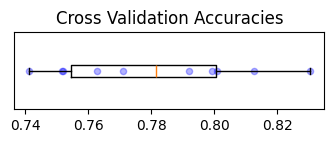

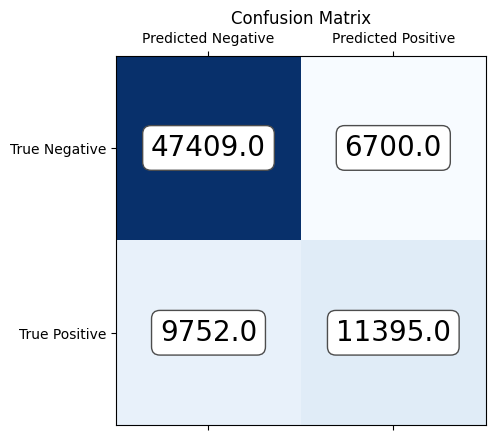

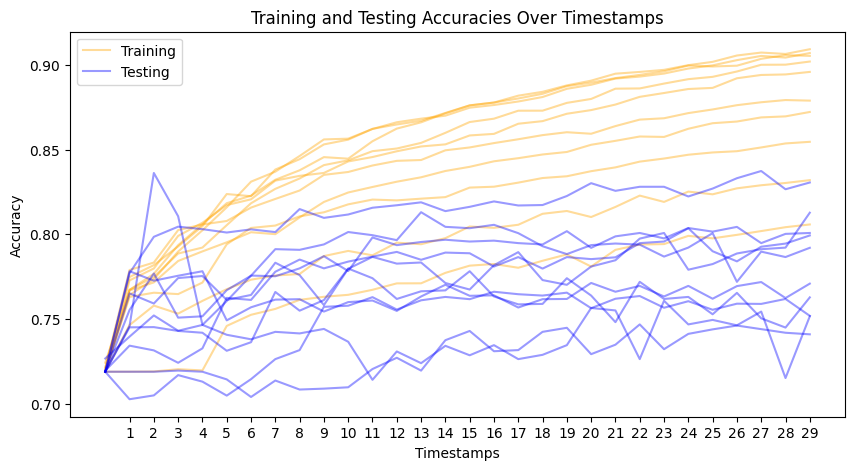

In [17]:
# Calculate overall statistics
last_epoch_test_data = history["test"][-1] #[fold, (pred, labels, accuracies, accuracy)]

all_confusion = np.sum(np.array([fold_data[0] for fold_data in last_epoch_test_data]), axis=0)
all_accuracies = [fold_data[1] for fold_data in last_epoch_test_data]

overall_accuracy = np.mean(all_accuracies)
correct_predictions = all_confusion[1][1] + all_confusion[0][0]
total_predictions = np.sum(all_confusion)

print(f"\nCross-Validation Results:")
print(f"Overall Accuracy: {overall_accuracy * 100:.2f}%")
print(f"Correct Predictions: {correct_predictions}/{total_predictions}")

fold_accuracies = [fold_data[1] for fold_data in history["test"][-1]]

from visualization_stuff import show_box_plot, show_confusion_matrix, show_train_and_test_accuracy_over_epochs
show_box_plot(fold_accuracies)

show_confusion_matrix(all_confusion)

show_train_and_test_accuracy_over_epochs(history)

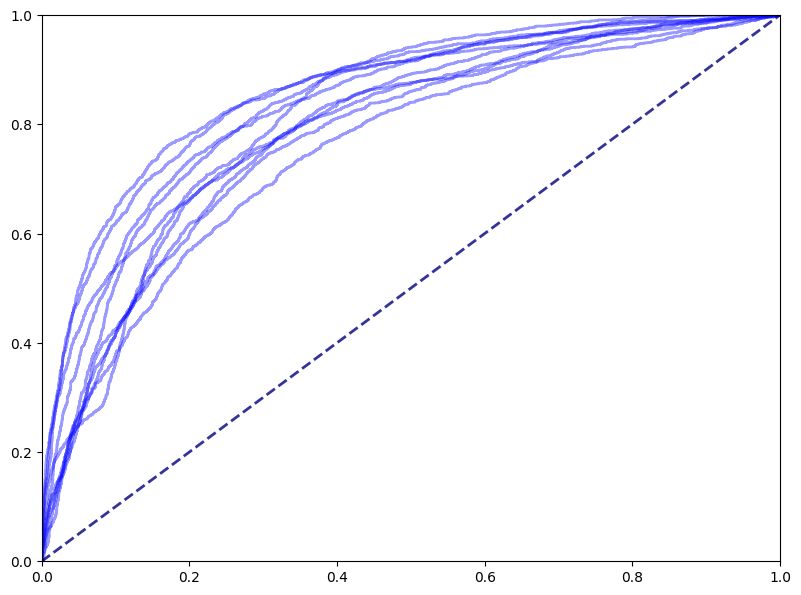

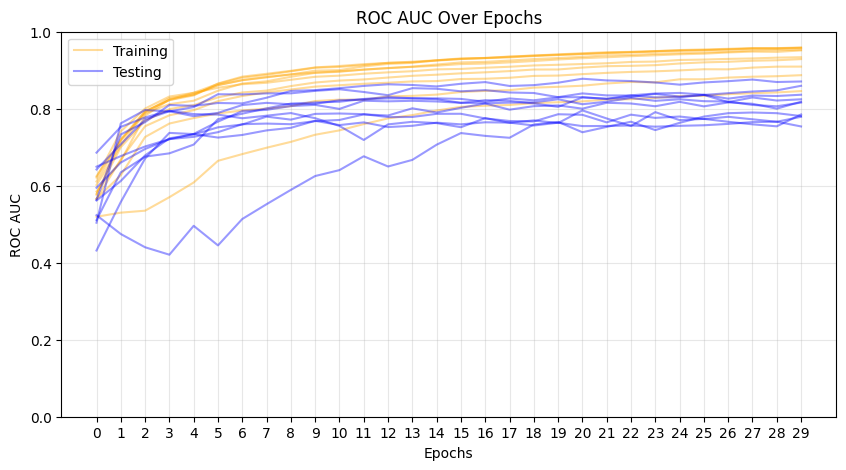

In [18]:
from visualization_stuff import show_multiple_roc_curves, show_roc_curves_over_epochs

show_multiple_roc_curves(history)

# Show ROC AUC progression over epochs (similar to accuracy plot)
train_fold_aucs, test_fold_aucs = show_roc_curves_over_epochs(history, "ROC AUC Over Epochs")

In [19]:
def show_classification_report(history):
    all_labels = []
    all_predictions = []
    for fold_data in history["test"][-1]:
        _, _, probabilities, true_labels = fold_data
        all_labels.extend(true_labels)
        all_predictions.extend([int(prob > .5) for prob in probabilities])
    from sklearn.metrics import classification_report
    print(classification_report(all_labels, all_predictions))

show_classification_report(history)

              precision    recall  f1-score   support

           0       0.83      0.88      0.85     54109
           1       0.63      0.54      0.58     21147

    accuracy                           0.78     75256
   macro avg       0.73      0.71      0.72     75256
weighted avg       0.77      0.78      0.78     75256



https://github.com/pytorch/examples/tree/main/word_language_model